# Correct the SWOT Karin "beta" data

See also `play_w_swot_karin.ipynb`

Steps:
- Use `ssha_karin`, not `ssh_karin_2` as it is supposedly more accurate albeit with more gaps
- Remove bad flags (keep suspect but not degraded)
- 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

In [2]:

# ds_area.to_netcdf('/home/jupyter-mrayson/data/SWOT/Karin_prelim_complete_calval_browsebasin.nc')
# region ='browsebasin'
region = 'pilbara'
ds = xr.open_dataset('/home/jupyter-mrayson/data/SWOT/Karin_prelim_complete_calval_{}.nc'.format(region))
ds

/home/jupyter-mrayson/.local/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/jupyter-mrayson/.local/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:                                (satpass: 89, num_lines: 375,
                                            num_pixels: 69, num_sides: 2)
Coordinates:
  * satpass                                (satpass) datetime64[ns] 2023-03-2...
    latitude                               (num_lines, num_pixels) float64 ...
    longitude                              (num_lines, num_pixels) float64 ...
    latitude_nadir                         (satpass, num_lines) float64 ...
    longitude_nadir                        (satpass, num_lines) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/96)
    time                                   (satpass, num_lines, num_pixels) datetime64[ns] ...
    time_tai                               (satpass, num_lines, num_pixels) datetime64[ns] ...
    ssh_karin                              (satpass, num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (satpass, num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (satpass, num_lines, num_pixels) float32 ...
    ssha_karin                             (satpass, num_lines, num_pixels) float64 ...
    ...                                     ...
    sea_state_bias_cor                     (satpass, num_lines, num_pixels) float32 ...
    sea_state_bias_cor_2                   (satpass, num_lines, num_pixels) float32 ...
    swh_ssb_cor_source                     (satpass, num_lines, num_pixels) float32 ...
    swh_ssb_cor_source_2                   (satpass, num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source              (satpass, num_lines, num_pixels) float32 ...
    wind_speed_ssb_cor_source_2            (satpass, num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-08-29T21:53:44Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   JPL
    references:                                    V1.1
    equator_time:                                  2023-03-29T04:25:16.563000Z
    equator_longitude:                             112.47
    product_version:                               01

In [3]:
for ii, ss in zip(ds['ssha_karin_qual'].flag_masks, ds['ssha_karin_qual'].flag_meanings.split(' ')):
    print('{}: {}'.format(ii, ss))

1: suspect_large_ssh_delta
2: suspect_large_ssh_std
4: suspect_large_ssh_window_std
8: suspect_beam_used
16: suspect_less_than_nine_beams
32: suspect_model_swh_used_ssb
64: suspect_ssb_out_of_range
128: suspect_pixel_used
256: suspect_num_pt_avg
1024: suspect_orbit_control
2048: suspect_sc_event_flag
4096: suspect_tvp_qual
8192: suspect_volumetric_corr
32768: degraded_ssb_not_computable
65536: degraded_media_delays_missing
131072: degraded_beam_used
262144: degraded_large_attitude
33554432: bad_very_large_attitude
67108864: bad_tide_corrections_missing
134217728: bad_ssb_missing
268435456: bad_radiometer_corr_missing
536870912: bad_outside_of_range
1073741824: degraded
2147483648: bad_not_usable


Definitions:
 - Suspect flags > 1
 - Degraded flags > 8192
 - Bad flags > 262144

In [4]:
def calc_corrected(ds_area, ii, datavar='ssha_karin', flags='degraded', verbose=False):
    if verbose:
        print(ii)
    data = ds_area.isel(satpass=ii)[datavar] + ds_area.isel(satpass=ii)['height_cor_xover']
    nanidx = ~np.isnan(data.values)

    # Remove flagged data
    flag_var = '{}_qual'.format(datavar)
    if flags == 'good':
        upperflag = 0
    elif flags == 'suspect':
        upperflag = 8192
    elif flags == 'degraded':
        upperflag = 262144
    elif flags == 'bad':
        upperflag = np.inf

    dataflag = ds_area.isel(satpass=ii)[flag_var]
    flagidx = dataflag <= upperflag

    idx = flagidx

    Xmu = data.longitude.values[idx].mean()
    Ymu = data.latitude.values[idx].mean()
    X = data.longitude.values[idx] - Xmu
    Y = data.latitude.values[idx] - Ymu
    
    N = Y.shape[0]
    if verbose:
        print(N)
    
    # Fit a quadratic function to account for "bowling" and "tilting"
    A = np.array([ X**2, Y**2, X, Y, np.ones(N,)]).T
    soln,_,_,_ = np.linalg.lstsq(A, data.values[idx])
    
    z_poly = soln[0]**2*(data['longitude'] -Xmu) +\
        soln[1]**2*(data['latitude'] -Ymu)+\
        soln[2]*(data['longitude']-Xmu) + \
        soln[3]*(data['latitude']-Ymu) + \
        soln[4]

    #A = np.array([ X, Y, np.ones(N,)]).T
    #soln,_,_,_ = np.linalg.lstsq(A, data.values[idx])
    #print(soln)
    #z_poly = soln[0]*data['longitude'] + soln[1]*data['latitude'] + soln[2]


    #data_zplane = data.copy()
    #data_zplane[:] = z_plane
    
    data_corrected = data - z_poly
    #data_corrected
    return data_corrected.where(idx, np.nan), z_poly.where(idx, np.nan)

In [5]:
def plot_var(data, vmin=-0.3, vmax=0.3, cmap='RdBu_r'):
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
    plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_kwargs={"shrink": 0.3},)
    data.plot.pcolormesh(ax=ax1, **plot_kwargs)
    plt.tight_layout()



3
15376


/tmp/ipykernel_1772/3291685583.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soln,_,_,_ = np.linalg.lstsq(A, data.values[idx])


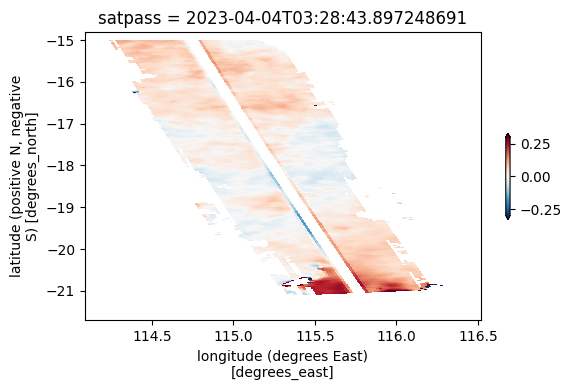

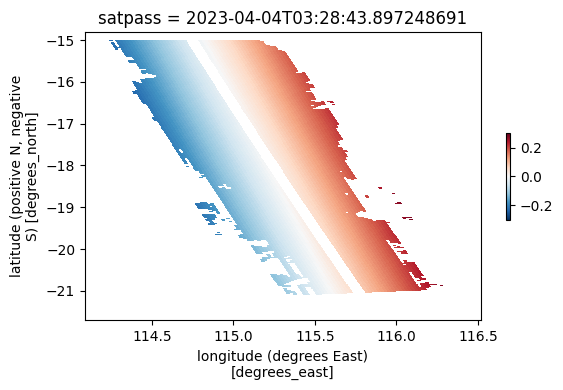

In [6]:
data, z_polyfit =calc_corrected(ds, 3, flags='degraded', verbose=True)
plot_var(data)
plot_var(z_polyfit)

In [7]:
from utils import plot_swot_basemap

def plot_corrected_nicemap(ii):
    fig=plt.figure(figsize=(12,6))
    
    
    
   
    #data_corrected = calc_corrected_v2(ii, plot=False)
    data_corrected, z_polyfit =calc_corrected(ds, ii, flags='degraded', verbose=True)
    # Calc SSH gradients
    
    plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="RdBu_r",
    vmin=-0.2,
    vmax=0.2,
    cbar_kwargs={"shrink": 0.3},)
    
    ax2=plt.subplot(122)
    plot_swot_basemap(ax2, [121.5, 124.5], [-15, -12], swath=False) 
    data_corrected.plot.pcolormesh(ax=ax2, **plot_kwargs)
    ax2.set_ylabel('')
    ax2.set_yticklabels([])
    ax2.set_title('Polynomial Corrected')
    
    ax1=plt.subplot(121)
    plot_swot_basemap(ax1, [121.5, 124.5], [-15, -12], swath=False) 
    (data_corrected+ z_polyfit).plot.pcolormesh(ax=ax1, **plot_kwargs)
    ax1.set_title(ds.satpass.values[ii])
    
    plt.tight_layout()

    outfile = '../FIGURES/SWOT/SWOT_Karin_BrowseBasin_polycorrection_{}.png'.format(ds.satpass.values[ii].astype(str)[0:10])
    print(outfile)
    plt.savefig(outfile, dpi=150)

    del fig
    del ax1, ax2

    

In [ ]:
# for ii in range(88):
#     plot_corrected_nicemap(ii)

In [8]:
data_f = []
data_z = []
for ii in range(88):
    data, z_polyfit =calc_corrected(ds, ii, flags='suspect', verbose=False)
    data_f.append(data)
    data_z.append(z_polyfit)

/tmp/ipykernel_1772/3291685583.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soln,_,_,_ = np.linalg.lstsq(A, data.values[idx])
/tmp/ipykernel_1772/3291685583.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  soln,_,_,_ = np.linalg.lstsq(A, data.values[idx])
/tmp/ipykernel_1772/3291685583.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `

In [9]:
ds_out = xr.Dataset({'ssha_karin_polycorrected':xr.concat(data_f, dim='satpass'),
    'polynomial_correction':xr.concat(data_z, dim='satpass')})
ds_out

<xarray.Dataset>
Dimensions:                   (satpass: 88, num_lines: 375, num_pixels: 69)
Coordinates:
  * satpass                   (satpass) datetime64[ns] 2023-03-29T04:24:49.07...
    latitude                  (num_lines, num_pixels) float64 -14.83 ... -21.69
    longitude                 (num_lines, num_pixels) float64 115.3 ... 115.2
    latitude_nadir            (satpass, num_lines) float64 -14.92 -14.94 ... nan
    longitude_nadir           (satpass, num_lines) float64 114.7 114.7 ... nan
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    ssha_karin_polycorrected  (satpass, num_lines, num_pixels) float64 nan .....
    polynomial_correction     (satpass, num_lines, num_pixels) float64 nan .....

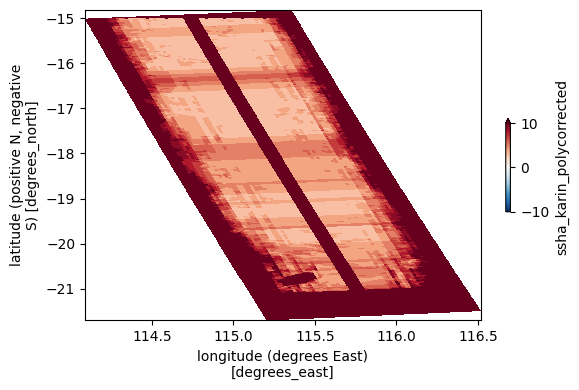

In [10]:
plot_var(-~np.isnan(ds_out['ssha_karin_polycorrected']).sum(axis=0), vmin=-10, vmax=10)

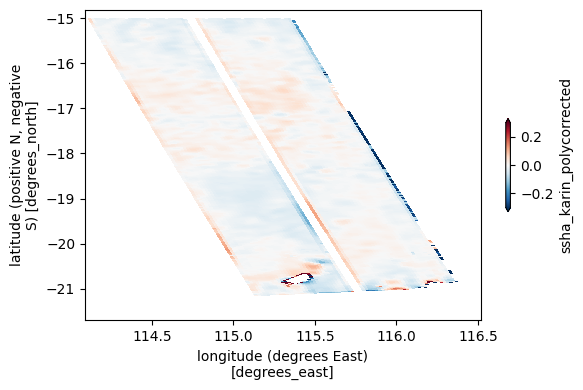

In [11]:
plot_var(ds_out['ssha_karin_polycorrected'].mean(axis=0))

In [12]:
outfile = '/home/jupyter-mrayson/data/SWOT/SWOT_Prelim_beta_karin_{}_polycorrection.nc'.format(region)
ds_out.to_netcdf(outfile)